# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

#FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [01:55<00:00, 518File/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

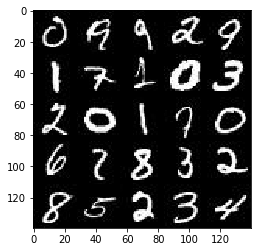

In [1]:

import helper
data_dir = './data'
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

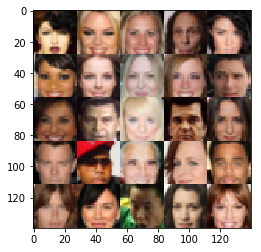

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [3]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [4]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32,(None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='inputs_z')
    learning_rate = tf.placeholder(tf.float32)
    

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [5]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    keep_prob = 1.0
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x?
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
                              #kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * x1, x1)
        drop1 = tf.nn.dropout(relu1, keep_prob=keep_prob)
        # 14x14x64
        
        x2 = tf.layers.conv2d(drop1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        drop2 = tf.nn.dropout(relu2, keep_prob=keep_prob)
        # 7x7x128
        
        x3 = tf.layers.conv2d(drop2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        drop3 = tf.nn.dropout(relu3, keep_prob=keep_prob)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(drop3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [6]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    keep_prob = 1.0
    with tf.variable_scope('generator', reuse= not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, keep_prob=keep_prob)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, keep_prob=keep_prob)
        # 7x7x256 now

        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, keep_prob=keep_prob)
        # 14x14x128 now

        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=1, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        x4 = tf.nn.dropout(x4, keep_prob=keep_prob)
        # 14x14x64 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=2, padding='same')
        # 28x28xout_channel_dim now
        
        out = tf.tanh(logits)
        
        return out
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [12]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.0
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                 labels=tf.ones_like(d_logits_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                        labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                       labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [8]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    #from IPython.core.debugger import Tracer; Tracer()()
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [10]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    tf.reset_default_graph()
    #from IPython.core.debugger import Tracer; Tracer()()

    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    losses = []
    steps = 0
    print_every = 10
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images *= 2
                steps += 1
                # TODO: Train Model
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr:learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, batch_size, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 4.2452... Generator Loss: 0.0173
Epoch 1/2... Discriminator Loss: 3.1243... Generator Loss: 0.1110
Epoch 1/2... Discriminator Loss: 1.1784... Generator Loss: 0.6288
Epoch 1/2... Discriminator Loss: 1.5828... Generator Loss: 0.7641
Epoch 1/2... Discriminator Loss: 2.8906... Generator Loss: 0.3174
Epoch 1/2... Discriminator Loss: 2.2022... Generator Loss: 0.4326
Epoch 1/2... Discriminator Loss: 2.4312... Generator Loss: 0.4737
Epoch 1/2... Discriminator Loss: 2.4149... Generator Loss: 0.4743
Epoch 1/2... Discriminator Loss: 1.3657... Generator Loss: 0.5935
Epoch 1/2... Discriminator Loss: 1.2205... Generator Loss: 0.7186


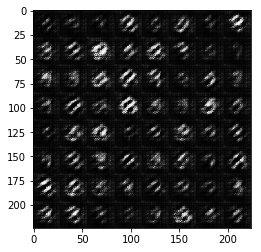

Epoch 1/2... Discriminator Loss: 1.4607... Generator Loss: 0.6705
Epoch 1/2... Discriminator Loss: 2.1033... Generator Loss: 0.4464
Epoch 1/2... Discriminator Loss: 1.6516... Generator Loss: 0.5617
Epoch 1/2... Discriminator Loss: 1.6634... Generator Loss: 0.4863
Epoch 1/2... Discriminator Loss: 1.6397... Generator Loss: 0.4841
Epoch 1/2... Discriminator Loss: 1.7825... Generator Loss: 0.4588
Epoch 1/2... Discriminator Loss: 1.6172... Generator Loss: 0.3971
Epoch 1/2... Discriminator Loss: 1.5344... Generator Loss: 0.8584
Epoch 1/2... Discriminator Loss: 1.4068... Generator Loss: 0.4687
Epoch 1/2... Discriminator Loss: 1.4230... Generator Loss: 0.7936


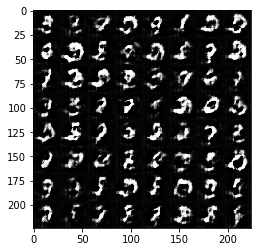

Epoch 1/2... Discriminator Loss: 1.4579... Generator Loss: 0.9167
Epoch 1/2... Discriminator Loss: 1.5341... Generator Loss: 0.6228
Epoch 1/2... Discriminator Loss: 1.5343... Generator Loss: 1.1354
Epoch 1/2... Discriminator Loss: 1.4523... Generator Loss: 0.6892
Epoch 1/2... Discriminator Loss: 1.6205... Generator Loss: 0.6222
Epoch 1/2... Discriminator Loss: 1.4520... Generator Loss: 0.4553
Epoch 1/2... Discriminator Loss: 1.4333... Generator Loss: 0.7032
Epoch 1/2... Discriminator Loss: 1.4118... Generator Loss: 0.7855
Epoch 1/2... Discriminator Loss: 1.4392... Generator Loss: 0.7469
Epoch 1/2... Discriminator Loss: 1.4195... Generator Loss: 0.6938


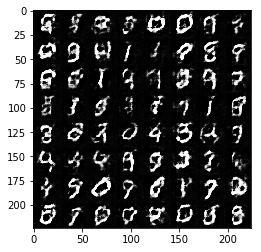

Epoch 1/2... Discriminator Loss: 1.3922... Generator Loss: 0.7383
Epoch 1/2... Discriminator Loss: 1.4811... Generator Loss: 0.7271
Epoch 1/2... Discriminator Loss: 1.5184... Generator Loss: 0.4542
Epoch 1/2... Discriminator Loss: 1.4705... Generator Loss: 0.5331
Epoch 1/2... Discriminator Loss: 1.4607... Generator Loss: 0.4262
Epoch 1/2... Discriminator Loss: 1.5432... Generator Loss: 0.4120
Epoch 1/2... Discriminator Loss: 1.4379... Generator Loss: 0.7410
Epoch 1/2... Discriminator Loss: 1.3426... Generator Loss: 0.8163
Epoch 1/2... Discriminator Loss: 1.5656... Generator Loss: 0.8801
Epoch 1/2... Discriminator Loss: 1.4889... Generator Loss: 0.4635


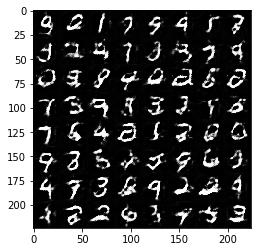

Epoch 1/2... Discriminator Loss: 1.4911... Generator Loss: 0.4480
Epoch 1/2... Discriminator Loss: 1.4559... Generator Loss: 0.8403
Epoch 1/2... Discriminator Loss: 1.5150... Generator Loss: 0.8201
Epoch 1/2... Discriminator Loss: 1.4865... Generator Loss: 0.4284
Epoch 1/2... Discriminator Loss: 1.4888... Generator Loss: 0.8411
Epoch 1/2... Discriminator Loss: 1.6233... Generator Loss: 0.3510
Epoch 1/2... Discriminator Loss: 1.5272... Generator Loss: 0.6635
Epoch 1/2... Discriminator Loss: 1.4040... Generator Loss: 0.6714
Epoch 1/2... Discriminator Loss: 1.4369... Generator Loss: 0.7680
Epoch 1/2... Discriminator Loss: 1.4476... Generator Loss: 0.9828


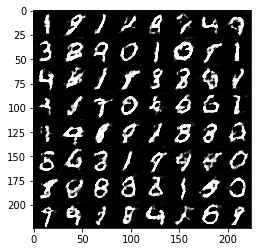

Epoch 1/2... Discriminator Loss: 1.3737... Generator Loss: 0.7432
Epoch 1/2... Discriminator Loss: 1.4188... Generator Loss: 1.0205
Epoch 1/2... Discriminator Loss: 1.5867... Generator Loss: 0.3244
Epoch 1/2... Discriminator Loss: 1.2936... Generator Loss: 0.8018
Epoch 1/2... Discriminator Loss: 1.4170... Generator Loss: 0.7029
Epoch 1/2... Discriminator Loss: 1.6936... Generator Loss: 0.3365
Epoch 1/2... Discriminator Loss: 1.3531... Generator Loss: 0.6719
Epoch 1/2... Discriminator Loss: 1.3962... Generator Loss: 0.5314
Epoch 1/2... Discriminator Loss: 1.3700... Generator Loss: 0.6529
Epoch 1/2... Discriminator Loss: 1.4696... Generator Loss: 0.8695


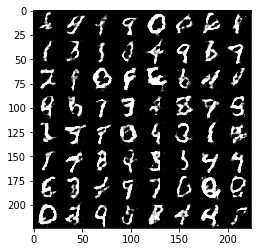

Epoch 1/2... Discriminator Loss: 1.4229... Generator Loss: 0.7516
Epoch 1/2... Discriminator Loss: 1.3194... Generator Loss: 0.6100
Epoch 1/2... Discriminator Loss: 1.3941... Generator Loss: 1.1722
Epoch 1/2... Discriminator Loss: 1.5752... Generator Loss: 0.8862
Epoch 1/2... Discriminator Loss: 1.4957... Generator Loss: 0.4254
Epoch 1/2... Discriminator Loss: 2.0759... Generator Loss: 1.1634
Epoch 1/2... Discriminator Loss: 1.4026... Generator Loss: 0.6710
Epoch 1/2... Discriminator Loss: 1.5233... Generator Loss: 0.6273
Epoch 1/2... Discriminator Loss: 1.6864... Generator Loss: 0.2829
Epoch 1/2... Discriminator Loss: 1.4318... Generator Loss: 0.5923


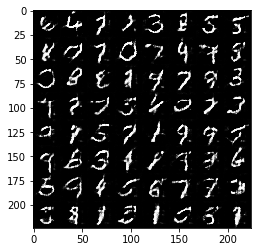

Epoch 1/2... Discriminator Loss: 1.4643... Generator Loss: 0.4901
Epoch 1/2... Discriminator Loss: 1.5397... Generator Loss: 0.6976
Epoch 1/2... Discriminator Loss: 1.9412... Generator Loss: 1.6611
Epoch 1/2... Discriminator Loss: 1.4549... Generator Loss: 0.5581
Epoch 1/2... Discriminator Loss: 1.3473... Generator Loss: 0.6678
Epoch 1/2... Discriminator Loss: 1.5567... Generator Loss: 1.0896
Epoch 1/2... Discriminator Loss: 1.4973... Generator Loss: 0.6703
Epoch 1/2... Discriminator Loss: 1.5721... Generator Loss: 0.4370
Epoch 1/2... Discriminator Loss: 1.4335... Generator Loss: 0.6347
Epoch 1/2... Discriminator Loss: 1.4395... Generator Loss: 0.4554


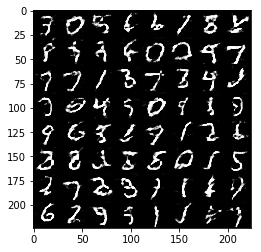

Epoch 1/2... Discriminator Loss: 1.3577... Generator Loss: 0.6930
Epoch 1/2... Discriminator Loss: 1.6962... Generator Loss: 0.2620
Epoch 1/2... Discriminator Loss: 1.4521... Generator Loss: 0.6775
Epoch 1/2... Discriminator Loss: 1.4156... Generator Loss: 0.6547
Epoch 1/2... Discriminator Loss: 1.4873... Generator Loss: 0.6010
Epoch 1/2... Discriminator Loss: 1.4630... Generator Loss: 0.4035
Epoch 1/2... Discriminator Loss: 1.6273... Generator Loss: 1.2080
Epoch 1/2... Discriminator Loss: 1.4199... Generator Loss: 0.5340
Epoch 1/2... Discriminator Loss: 1.5725... Generator Loss: 1.1660
Epoch 1/2... Discriminator Loss: 1.3463... Generator Loss: 0.6234


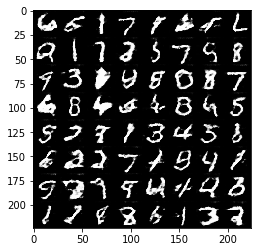

Epoch 1/2... Discriminator Loss: 1.4580... Generator Loss: 0.5783
Epoch 1/2... Discriminator Loss: 1.2995... Generator Loss: 0.6942
Epoch 1/2... Discriminator Loss: 1.6119... Generator Loss: 0.3433
Epoch 2/2... Discriminator Loss: 1.5406... Generator Loss: 0.4132
Epoch 2/2... Discriminator Loss: 1.3173... Generator Loss: 0.6653
Epoch 2/2... Discriminator Loss: 1.9613... Generator Loss: 0.1846
Epoch 2/2... Discriminator Loss: 1.5144... Generator Loss: 0.4830
Epoch 2/2... Discriminator Loss: 1.3792... Generator Loss: 0.5273
Epoch 2/2... Discriminator Loss: 1.3269... Generator Loss: 0.6369
Epoch 2/2... Discriminator Loss: 1.4223... Generator Loss: 0.9075


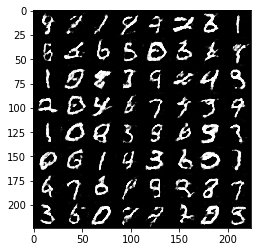

Epoch 2/2... Discriminator Loss: 1.3192... Generator Loss: 0.5634
Epoch 2/2... Discriminator Loss: 1.3696... Generator Loss: 0.6953
Epoch 2/2... Discriminator Loss: 1.4444... Generator Loss: 0.4822
Epoch 2/2... Discriminator Loss: 1.3850... Generator Loss: 0.4999
Epoch 2/2... Discriminator Loss: 1.4780... Generator Loss: 0.4221
Epoch 2/2... Discriminator Loss: 1.4468... Generator Loss: 0.5764
Epoch 2/2... Discriminator Loss: 1.3666... Generator Loss: 0.7057
Epoch 2/2... Discriminator Loss: 1.3634... Generator Loss: 0.7025
Epoch 2/2... Discriminator Loss: 1.3981... Generator Loss: 0.5881
Epoch 2/2... Discriminator Loss: 1.4248... Generator Loss: 0.6495


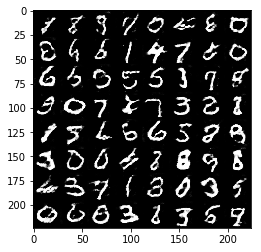

Epoch 2/2... Discriminator Loss: 1.4945... Generator Loss: 0.4459
Epoch 2/2... Discriminator Loss: 1.4031... Generator Loss: 0.6422
Epoch 2/2... Discriminator Loss: 1.3526... Generator Loss: 0.8361
Epoch 2/2... Discriminator Loss: 1.4331... Generator Loss: 0.5773
Epoch 2/2... Discriminator Loss: 1.6011... Generator Loss: 0.5067
Epoch 2/2... Discriminator Loss: 1.3824... Generator Loss: 0.6018
Epoch 2/2... Discriminator Loss: 1.2519... Generator Loss: 0.7266
Epoch 2/2... Discriminator Loss: 1.3402... Generator Loss: 0.5988
Epoch 2/2... Discriminator Loss: 1.3215... Generator Loss: 0.5829
Epoch 2/2... Discriminator Loss: 1.4322... Generator Loss: 0.4432


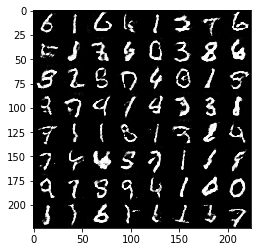

Epoch 2/2... Discriminator Loss: 1.6846... Generator Loss: 0.2766
Epoch 2/2... Discriminator Loss: 1.7548... Generator Loss: 1.7539
Epoch 2/2... Discriminator Loss: 1.3004... Generator Loss: 0.6429
Epoch 2/2... Discriminator Loss: 1.7088... Generator Loss: 0.2789
Epoch 2/2... Discriminator Loss: 1.4268... Generator Loss: 0.5015
Epoch 2/2... Discriminator Loss: 1.3760... Generator Loss: 0.6153
Epoch 2/2... Discriminator Loss: 1.3264... Generator Loss: 0.9885
Epoch 2/2... Discriminator Loss: 1.3467... Generator Loss: 0.5139
Epoch 2/2... Discriminator Loss: 1.2388... Generator Loss: 0.7244
Epoch 2/2... Discriminator Loss: 1.1905... Generator Loss: 0.9873


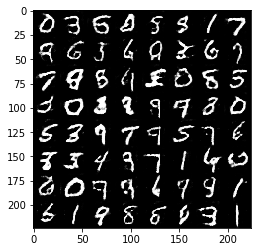

Epoch 2/2... Discriminator Loss: 1.3252... Generator Loss: 0.7953
Epoch 2/2... Discriminator Loss: 1.5291... Generator Loss: 0.9164
Epoch 2/2... Discriminator Loss: 1.3980... Generator Loss: 0.5773
Epoch 2/2... Discriminator Loss: 1.5471... Generator Loss: 0.3582
Epoch 2/2... Discriminator Loss: 1.5746... Generator Loss: 0.4001
Epoch 2/2... Discriminator Loss: 1.3002... Generator Loss: 0.7339
Epoch 2/2... Discriminator Loss: 1.3534... Generator Loss: 0.7139
Epoch 2/2... Discriminator Loss: 1.4367... Generator Loss: 0.4269
Epoch 2/2... Discriminator Loss: 1.5264... Generator Loss: 0.4810
Epoch 2/2... Discriminator Loss: 1.3549... Generator Loss: 0.6757


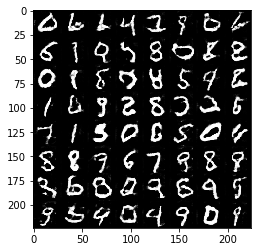

Epoch 2/2... Discriminator Loss: 1.3975... Generator Loss: 0.5407
Epoch 2/2... Discriminator Loss: 1.4665... Generator Loss: 0.4527
Epoch 2/2... Discriminator Loss: 1.3010... Generator Loss: 1.0552
Epoch 2/2... Discriminator Loss: 1.4954... Generator Loss: 0.4518
Epoch 2/2... Discriminator Loss: 1.9310... Generator Loss: 1.4856
Epoch 2/2... Discriminator Loss: 1.3791... Generator Loss: 0.7359
Epoch 2/2... Discriminator Loss: 1.3687... Generator Loss: 0.6837
Epoch 2/2... Discriminator Loss: 1.4215... Generator Loss: 0.4425
Epoch 2/2... Discriminator Loss: 1.5664... Generator Loss: 0.3155
Epoch 2/2... Discriminator Loss: 1.6109... Generator Loss: 0.3765


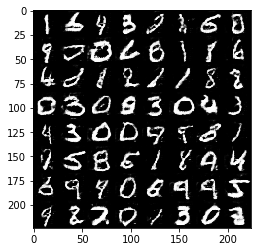

Epoch 2/2... Discriminator Loss: 1.7433... Generator Loss: 0.3199
Epoch 2/2... Discriminator Loss: 1.3105... Generator Loss: 0.9671
Epoch 2/2... Discriminator Loss: 1.4224... Generator Loss: 0.4630
Epoch 2/2... Discriminator Loss: 1.3321... Generator Loss: 0.6888
Epoch 2/2... Discriminator Loss: 1.5981... Generator Loss: 0.2977
Epoch 2/2... Discriminator Loss: 1.3747... Generator Loss: 0.5659
Epoch 2/2... Discriminator Loss: 1.4460... Generator Loss: 0.4923
Epoch 2/2... Discriminator Loss: 1.8241... Generator Loss: 0.2635
Epoch 2/2... Discriminator Loss: 1.4588... Generator Loss: 0.4468
Epoch 2/2... Discriminator Loss: 1.5177... Generator Loss: 0.3959


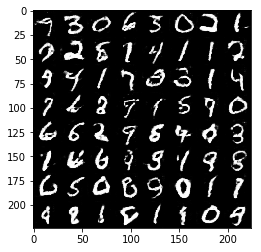

Epoch 2/2... Discriminator Loss: 1.9870... Generator Loss: 1.7269
Epoch 2/2... Discriminator Loss: 1.4138... Generator Loss: 0.6105
Epoch 2/2... Discriminator Loss: 1.2737... Generator Loss: 0.7046
Epoch 2/2... Discriminator Loss: 1.4230... Generator Loss: 0.7909
Epoch 2/2... Discriminator Loss: 1.4230... Generator Loss: 0.9402
Epoch 2/2... Discriminator Loss: 1.2830... Generator Loss: 0.7883
Epoch 2/2... Discriminator Loss: 1.3142... Generator Loss: 1.0717
Epoch 2/2... Discriminator Loss: 1.3159... Generator Loss: 0.8301
Epoch 2/2... Discriminator Loss: 1.6942... Generator Loss: 0.2774
Epoch 2/2... Discriminator Loss: 1.4111... Generator Loss: 0.5031


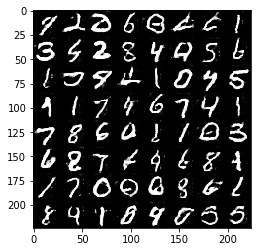

Epoch 2/2... Discriminator Loss: 1.6094... Generator Loss: 1.3257
Epoch 2/2... Discriminator Loss: 1.3143... Generator Loss: 0.5428
Epoch 2/2... Discriminator Loss: 1.7201... Generator Loss: 0.2897
Epoch 2/2... Discriminator Loss: 1.5225... Generator Loss: 0.8253
Epoch 2/2... Discriminator Loss: 1.3259... Generator Loss: 0.5836
Epoch 2/2... Discriminator Loss: 1.4728... Generator Loss: 0.4801
Epoch 2/2... Discriminator Loss: 1.2618... Generator Loss: 1.2409
Epoch 2/2... Discriminator Loss: 1.2212... Generator Loss: 0.6575
Epoch 2/2... Discriminator Loss: 1.4616... Generator Loss: 0.6373
Epoch 2/2... Discriminator Loss: 1.4643... Generator Loss: 0.4794


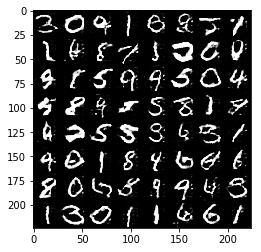

Epoch 2/2... Discriminator Loss: 1.6060... Generator Loss: 0.3233
Epoch 2/2... Discriminator Loss: 1.2550... Generator Loss: 0.7093
Epoch 2/2... Discriminator Loss: 1.4263... Generator Loss: 0.4743
Epoch 2/2... Discriminator Loss: 1.3435... Generator Loss: 0.8185
Epoch 2/2... Discriminator Loss: 1.4409... Generator Loss: 0.5634
Epoch 2/2... Discriminator Loss: 1.5795... Generator Loss: 0.3168
Epoch 2/2... Discriminator Loss: 1.4770... Generator Loss: 0.4224


IndexError: list index out of range

In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
#from IPython.core.debugger import Tracer; Tracer()()
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 4.6100... Generator Loss: 0.1549
Epoch 1/1... Discriminator Loss: 4.2836... Generator Loss: 0.0586
Epoch 1/1... Discriminator Loss: 2.5553... Generator Loss: 0.4967
Epoch 1/1... Discriminator Loss: 2.4946... Generator Loss: 0.3797
Epoch 1/1... Discriminator Loss: 1.9660... Generator Loss: 0.5770
Epoch 1/1... Discriminator Loss: 1.4595... Generator Loss: 0.7147
Epoch 1/1... Discriminator Loss: 1.7096... Generator Loss: 0.5537
Epoch 1/1... Discriminator Loss: 2.0898... Generator Loss: 0.3301
Epoch 1/1... Discriminator Loss: 1.6390... Generator Loss: 0.6506
Epoch 1/1... Discriminator Loss: 1.4219... Generator Loss: 0.8382


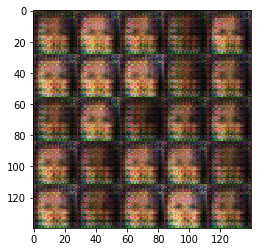

Epoch 1/1... Discriminator Loss: 1.6916... Generator Loss: 0.8124
Epoch 1/1... Discriminator Loss: 1.8562... Generator Loss: 0.4195
Epoch 1/1... Discriminator Loss: 2.2243... Generator Loss: 0.8337
Epoch 1/1... Discriminator Loss: 2.4696... Generator Loss: 0.2007
Epoch 1/1... Discriminator Loss: 1.1083... Generator Loss: 0.8833
Epoch 1/1... Discriminator Loss: 1.7700... Generator Loss: 0.6959
Epoch 1/1... Discriminator Loss: 1.7761... Generator Loss: 0.4736
Epoch 1/1... Discriminator Loss: 1.4076... Generator Loss: 0.6483
Epoch 1/1... Discriminator Loss: 2.1159... Generator Loss: 0.7621
Epoch 1/1... Discriminator Loss: 1.3552... Generator Loss: 0.7392


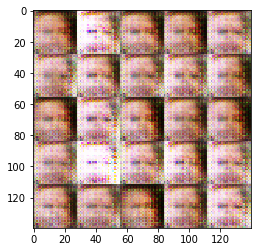

Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.7758
Epoch 1/1... Discriminator Loss: 1.9850... Generator Loss: 0.3454
Epoch 1/1... Discriminator Loss: 2.0550... Generator Loss: 0.4340
Epoch 1/1... Discriminator Loss: 1.7308... Generator Loss: 0.5345
Epoch 1/1... Discriminator Loss: 2.0436... Generator Loss: 0.3810
Epoch 1/1... Discriminator Loss: 1.6005... Generator Loss: 0.6182
Epoch 1/1... Discriminator Loss: 1.7977... Generator Loss: 0.4898
Epoch 1/1... Discriminator Loss: 1.6565... Generator Loss: 0.5260
Epoch 1/1... Discriminator Loss: 1.5555... Generator Loss: 0.5958
Epoch 1/1... Discriminator Loss: 1.4620... Generator Loss: 0.6260


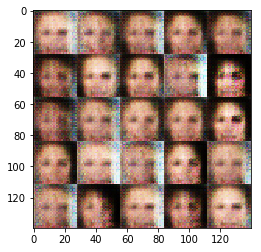

Epoch 1/1... Discriminator Loss: 1.4856... Generator Loss: 0.5545
Epoch 1/1... Discriminator Loss: 1.5175... Generator Loss: 0.6330
Epoch 1/1... Discriminator Loss: 1.4253... Generator Loss: 0.7311
Epoch 1/1... Discriminator Loss: 1.3824... Generator Loss: 0.7377
Epoch 1/1... Discriminator Loss: 1.5204... Generator Loss: 0.7689
Epoch 1/1... Discriminator Loss: 1.3638... Generator Loss: 0.7892
Epoch 1/1... Discriminator Loss: 1.5925... Generator Loss: 0.7006
Epoch 1/1... Discriminator Loss: 1.3975... Generator Loss: 0.7030
Epoch 1/1... Discriminator Loss: 1.4670... Generator Loss: 0.6212
Epoch 1/1... Discriminator Loss: 1.4793... Generator Loss: 0.5966


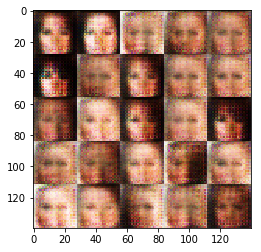

Epoch 1/1... Discriminator Loss: 1.5845... Generator Loss: 0.6613
Epoch 1/1... Discriminator Loss: 1.5004... Generator Loss: 0.7778
Epoch 1/1... Discriminator Loss: 1.9094... Generator Loss: 0.4952
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.7597
Epoch 1/1... Discriminator Loss: 1.4190... Generator Loss: 0.6945
Epoch 1/1... Discriminator Loss: 1.4561... Generator Loss: 0.7313
Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 0.6479
Epoch 1/1... Discriminator Loss: 1.5167... Generator Loss: 0.6135
Epoch 1/1... Discriminator Loss: 1.5704... Generator Loss: 0.5913
Epoch 1/1... Discriminator Loss: 1.4353... Generator Loss: 0.6510


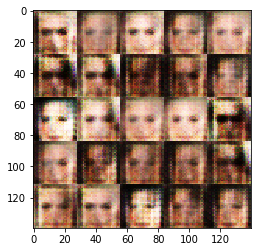

Epoch 1/1... Discriminator Loss: 1.7812... Generator Loss: 0.5718
Epoch 1/1... Discriminator Loss: 1.2173... Generator Loss: 0.7168
Epoch 1/1... Discriminator Loss: 1.5935... Generator Loss: 0.5723
Epoch 1/1... Discriminator Loss: 1.4679... Generator Loss: 0.6570
Epoch 1/1... Discriminator Loss: 1.4389... Generator Loss: 0.7133
Epoch 1/1... Discriminator Loss: 1.4652... Generator Loss: 0.6386
Epoch 1/1... Discriminator Loss: 1.4500... Generator Loss: 0.6510
Epoch 1/1... Discriminator Loss: 1.4917... Generator Loss: 0.5429
Epoch 1/1... Discriminator Loss: 1.4985... Generator Loss: 0.6190
Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.6377


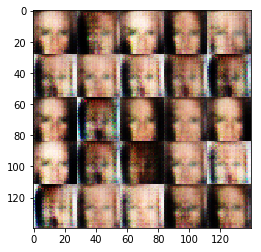

Epoch 1/1... Discriminator Loss: 1.5254... Generator Loss: 0.5804
Epoch 1/1... Discriminator Loss: 1.5141... Generator Loss: 0.7031
Epoch 1/1... Discriminator Loss: 1.5835... Generator Loss: 0.6031
Epoch 1/1... Discriminator Loss: 1.5429... Generator Loss: 0.5351
Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 0.5498
Epoch 1/1... Discriminator Loss: 1.5082... Generator Loss: 0.5413
Epoch 1/1... Discriminator Loss: 1.4932... Generator Loss: 0.6235
Epoch 1/1... Discriminator Loss: 1.5605... Generator Loss: 0.5461
Epoch 1/1... Discriminator Loss: 1.7608... Generator Loss: 0.5494
Epoch 1/1... Discriminator Loss: 1.6353... Generator Loss: 0.6318


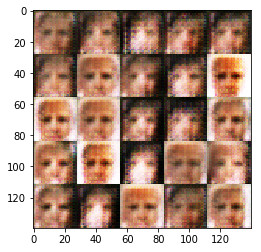

Epoch 1/1... Discriminator Loss: 1.4870... Generator Loss: 0.7417
Epoch 1/1... Discriminator Loss: 1.4939... Generator Loss: 0.5985
Epoch 1/1... Discriminator Loss: 1.4286... Generator Loss: 0.6578
Epoch 1/1... Discriminator Loss: 1.4462... Generator Loss: 0.6322
Epoch 1/1... Discriminator Loss: 1.5546... Generator Loss: 0.6586
Epoch 1/1... Discriminator Loss: 1.4094... Generator Loss: 0.6982
Epoch 1/1... Discriminator Loss: 1.8180... Generator Loss: 0.5155
Epoch 1/1... Discriminator Loss: 1.5332... Generator Loss: 0.6283
Epoch 1/1... Discriminator Loss: 1.4728... Generator Loss: 0.6983
Epoch 1/1... Discriminator Loss: 1.5066... Generator Loss: 0.6211


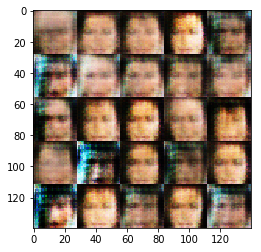

Epoch 1/1... Discriminator Loss: 1.5327... Generator Loss: 0.5999
Epoch 1/1... Discriminator Loss: 1.4160... Generator Loss: 0.6738
Epoch 1/1... Discriminator Loss: 1.5739... Generator Loss: 0.6390
Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.6884
Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.6808
Epoch 1/1... Discriminator Loss: 1.5382... Generator Loss: 0.5653
Epoch 1/1... Discriminator Loss: 1.5235... Generator Loss: 0.6197
Epoch 1/1... Discriminator Loss: 1.4501... Generator Loss: 0.6213
Epoch 1/1... Discriminator Loss: 1.4897... Generator Loss: 0.6849
Epoch 1/1... Discriminator Loss: 1.4579... Generator Loss: 0.5838


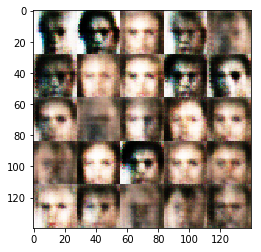

Epoch 1/1... Discriminator Loss: 1.4851... Generator Loss: 0.6422
Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 0.6893
Epoch 1/1... Discriminator Loss: 1.5269... Generator Loss: 0.6354
Epoch 1/1... Discriminator Loss: 1.4435... Generator Loss: 0.6657
Epoch 1/1... Discriminator Loss: 1.4702... Generator Loss: 0.6812
Epoch 1/1... Discriminator Loss: 1.4253... Generator Loss: 0.6430
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.7409
Epoch 1/1... Discriminator Loss: 1.4246... Generator Loss: 0.6665
Epoch 1/1... Discriminator Loss: 1.5597... Generator Loss: 0.5400
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.7323


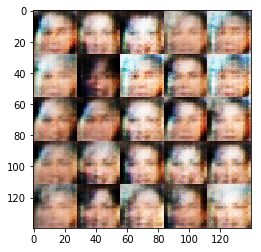

Epoch 1/1... Discriminator Loss: 1.3402... Generator Loss: 0.7409
Epoch 1/1... Discriminator Loss: 1.4857... Generator Loss: 0.6175
Epoch 1/1... Discriminator Loss: 1.5217... Generator Loss: 0.6292
Epoch 1/1... Discriminator Loss: 1.3677... Generator Loss: 0.6391
Epoch 1/1... Discriminator Loss: 1.4444... Generator Loss: 0.6559
Epoch 1/1... Discriminator Loss: 1.4611... Generator Loss: 0.6358
Epoch 1/1... Discriminator Loss: 1.4578... Generator Loss: 0.6275
Epoch 1/1... Discriminator Loss: 1.4340... Generator Loss: 0.6107
Epoch 1/1... Discriminator Loss: 1.5496... Generator Loss: 0.5611
Epoch 1/1... Discriminator Loss: 1.5053... Generator Loss: 0.6584


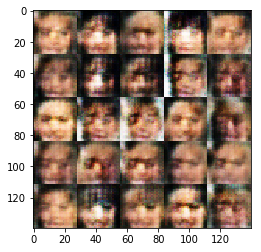

Epoch 1/1... Discriminator Loss: 1.5303... Generator Loss: 0.5655
Epoch 1/1... Discriminator Loss: 1.5119... Generator Loss: 0.5418
Epoch 1/1... Discriminator Loss: 1.4447... Generator Loss: 0.6706
Epoch 1/1... Discriminator Loss: 1.5839... Generator Loss: 0.6425
Epoch 1/1... Discriminator Loss: 1.6163... Generator Loss: 0.4774
Epoch 1/1... Discriminator Loss: 1.5542... Generator Loss: 0.6531
Epoch 1/1... Discriminator Loss: 1.4405... Generator Loss: 0.5988
Epoch 1/1... Discriminator Loss: 1.4251... Generator Loss: 0.6631
Epoch 1/1... Discriminator Loss: 1.4498... Generator Loss: 0.6333
Epoch 1/1... Discriminator Loss: 1.5013... Generator Loss: 0.6561


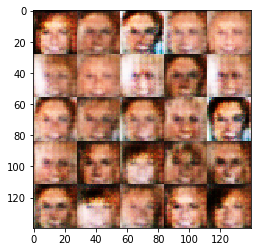

Epoch 1/1... Discriminator Loss: 1.4725... Generator Loss: 0.6614
Epoch 1/1... Discriminator Loss: 1.4459... Generator Loss: 0.6974
Epoch 1/1... Discriminator Loss: 1.5381... Generator Loss: 0.6776
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.6696
Epoch 1/1... Discriminator Loss: 1.5403... Generator Loss: 0.6168
Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 0.5991
Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.6662
Epoch 1/1... Discriminator Loss: 1.4456... Generator Loss: 0.5680
Epoch 1/1... Discriminator Loss: 1.4851... Generator Loss: 0.6404
Epoch 1/1... Discriminator Loss: 1.4149... Generator Loss: 0.7174


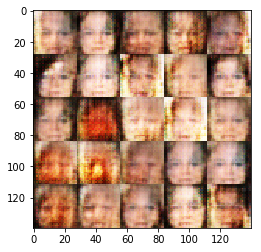

Epoch 1/1... Discriminator Loss: 1.4816... Generator Loss: 0.6858
Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.6540
Epoch 1/1... Discriminator Loss: 1.4217... Generator Loss: 0.6792
Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.6958
Epoch 1/1... Discriminator Loss: 1.4540... Generator Loss: 0.5971
Epoch 1/1... Discriminator Loss: 1.4604... Generator Loss: 0.6890
Epoch 1/1... Discriminator Loss: 1.5181... Generator Loss: 0.6567
Epoch 1/1... Discriminator Loss: 1.4381... Generator Loss: 0.6224
Epoch 1/1... Discriminator Loss: 1.4279... Generator Loss: 0.6465
Epoch 1/1... Discriminator Loss: 1.6104... Generator Loss: 0.6405


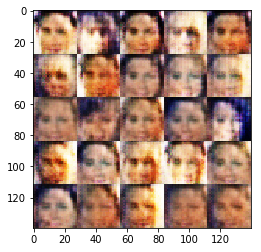

Epoch 1/1... Discriminator Loss: 1.4728... Generator Loss: 0.7032
Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.5827
Epoch 1/1... Discriminator Loss: 1.5581... Generator Loss: 0.6718
Epoch 1/1... Discriminator Loss: 1.5011... Generator Loss: 0.5970
Epoch 1/1... Discriminator Loss: 1.4266... Generator Loss: 0.7342
Epoch 1/1... Discriminator Loss: 1.4334... Generator Loss: 0.6916
Epoch 1/1... Discriminator Loss: 1.4479... Generator Loss: 0.6741
Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.6550
Epoch 1/1... Discriminator Loss: 1.5086... Generator Loss: 0.6218
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.7044


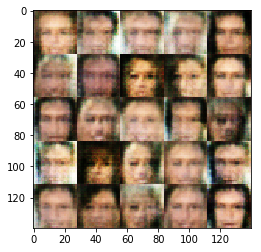

Epoch 1/1... Discriminator Loss: 1.4826... Generator Loss: 0.5950
Epoch 1/1... Discriminator Loss: 1.4692... Generator Loss: 0.6732
Epoch 1/1... Discriminator Loss: 1.3587... Generator Loss: 0.8031
Epoch 1/1... Discriminator Loss: 1.4003... Generator Loss: 0.7575
Epoch 1/1... Discriminator Loss: 1.4805... Generator Loss: 0.5564
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.7107
Epoch 1/1... Discriminator Loss: 1.4757... Generator Loss: 0.7180
Epoch 1/1... Discriminator Loss: 1.4598... Generator Loss: 0.5611
Epoch 1/1... Discriminator Loss: 1.4522... Generator Loss: 0.6733
Epoch 1/1... Discriminator Loss: 1.5841... Generator Loss: 0.5382


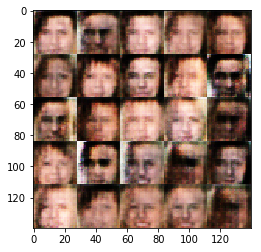

Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.6858
Epoch 1/1... Discriminator Loss: 1.6324... Generator Loss: 0.5502
Epoch 1/1... Discriminator Loss: 1.5155... Generator Loss: 0.7050
Epoch 1/1... Discriminator Loss: 1.5181... Generator Loss: 0.5723
Epoch 1/1... Discriminator Loss: 1.5811... Generator Loss: 0.6872
Epoch 1/1... Discriminator Loss: 1.3620... Generator Loss: 0.6342
Epoch 1/1... Discriminator Loss: 1.3836... Generator Loss: 0.6462
Epoch 1/1... Discriminator Loss: 1.4408... Generator Loss: 0.7026
Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 0.6382
Epoch 1/1... Discriminator Loss: 1.4266... Generator Loss: 0.6914


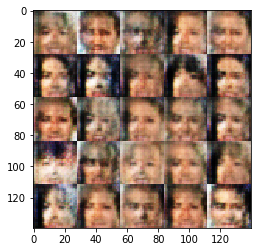

Epoch 1/1... Discriminator Loss: 1.4438... Generator Loss: 0.6490
Epoch 1/1... Discriminator Loss: 1.4539... Generator Loss: 0.6665
Epoch 1/1... Discriminator Loss: 1.4195... Generator Loss: 0.7088
Epoch 1/1... Discriminator Loss: 1.4188... Generator Loss: 0.6478
Epoch 1/1... Discriminator Loss: 1.4581... Generator Loss: 0.7249
Epoch 1/1... Discriminator Loss: 1.4957... Generator Loss: 0.6065
Epoch 1/1... Discriminator Loss: 1.5081... Generator Loss: 0.5717
Epoch 1/1... Discriminator Loss: 1.5242... Generator Loss: 0.6497
Epoch 1/1... Discriminator Loss: 1.4652... Generator Loss: 0.7732
Epoch 1/1... Discriminator Loss: 1.4451... Generator Loss: 0.6644


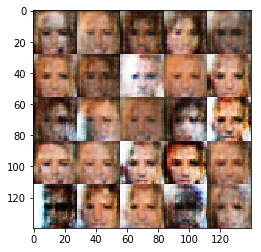

Epoch 1/1... Discriminator Loss: 1.4501... Generator Loss: 0.6108
Epoch 1/1... Discriminator Loss: 1.4635... Generator Loss: 0.5976
Epoch 1/1... Discriminator Loss: 1.3425... Generator Loss: 0.7685
Epoch 1/1... Discriminator Loss: 1.5195... Generator Loss: 0.7027
Epoch 1/1... Discriminator Loss: 1.4782... Generator Loss: 0.6837
Epoch 1/1... Discriminator Loss: 1.4879... Generator Loss: 0.6413
Epoch 1/1... Discriminator Loss: 1.5007... Generator Loss: 0.5719
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.6718
Epoch 1/1... Discriminator Loss: 1.4285... Generator Loss: 0.6674
Epoch 1/1... Discriminator Loss: 1.4532... Generator Loss: 0.6274


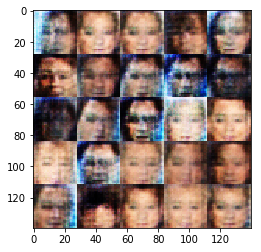

Epoch 1/1... Discriminator Loss: 1.4433... Generator Loss: 0.6222
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.6777
Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.6515
Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.6847
Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.6762
Epoch 1/1... Discriminator Loss: 1.4682... Generator Loss: 0.7501
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.6532
Epoch 1/1... Discriminator Loss: 1.5320... Generator Loss: 0.5935
Epoch 1/1... Discriminator Loss: 1.4200... Generator Loss: 0.7377
Epoch 1/1... Discriminator Loss: 1.5367... Generator Loss: 0.5920


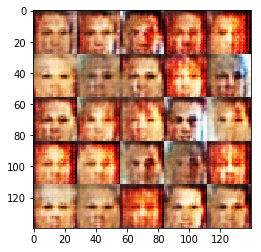

Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 0.6571
Epoch 1/1... Discriminator Loss: 1.4602... Generator Loss: 0.6336
Epoch 1/1... Discriminator Loss: 1.4068... Generator Loss: 0.7114
Epoch 1/1... Discriminator Loss: 1.4278... Generator Loss: 0.6269
Epoch 1/1... Discriminator Loss: 1.4804... Generator Loss: 0.6184
Epoch 1/1... Discriminator Loss: 1.4438... Generator Loss: 0.5875
Epoch 1/1... Discriminator Loss: 1.5012... Generator Loss: 0.6662
Epoch 1/1... Discriminator Loss: 1.5603... Generator Loss: 0.6473
Epoch 1/1... Discriminator Loss: 1.5120... Generator Loss: 0.6158
Epoch 1/1... Discriminator Loss: 1.5609... Generator Loss: 0.6419


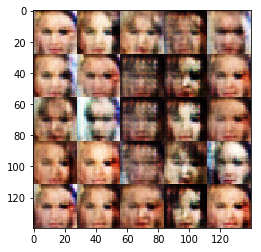

Epoch 1/1... Discriminator Loss: 1.4715... Generator Loss: 0.5755
Epoch 1/1... Discriminator Loss: 1.4500... Generator Loss: 0.7199
Epoch 1/1... Discriminator Loss: 1.4852... Generator Loss: 0.7346
Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 0.6616
Epoch 1/1... Discriminator Loss: 1.4831... Generator Loss: 0.6378
Epoch 1/1... Discriminator Loss: 1.3894... Generator Loss: 0.7133
Epoch 1/1... Discriminator Loss: 1.5032... Generator Loss: 0.6090
Epoch 1/1... Discriminator Loss: 1.4270... Generator Loss: 0.6380
Epoch 1/1... Discriminator Loss: 1.4338... Generator Loss: 0.6137
Epoch 1/1... Discriminator Loss: 1.4115... Generator Loss: 0.6463


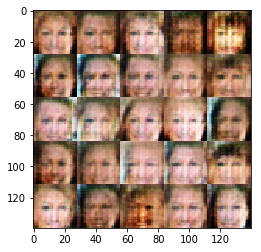

Epoch 1/1... Discriminator Loss: 1.5152... Generator Loss: 0.6708
Epoch 1/1... Discriminator Loss: 1.4710... Generator Loss: 0.7550
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.7398
Epoch 1/1... Discriminator Loss: 1.4520... Generator Loss: 0.6107
Epoch 1/1... Discriminator Loss: 1.4397... Generator Loss: 0.6401
Epoch 1/1... Discriminator Loss: 1.4547... Generator Loss: 0.6734
Epoch 1/1... Discriminator Loss: 1.4094... Generator Loss: 0.6634
Epoch 1/1... Discriminator Loss: 1.4218... Generator Loss: 0.6516
Epoch 1/1... Discriminator Loss: 1.4556... Generator Loss: 0.6144
Epoch 1/1... Discriminator Loss: 1.4273... Generator Loss: 0.6654


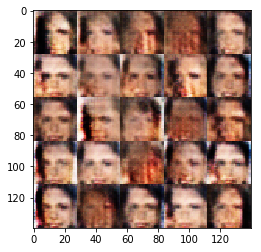

Epoch 1/1... Discriminator Loss: 1.6014... Generator Loss: 0.6011
Epoch 1/1... Discriminator Loss: 1.5644... Generator Loss: 0.5952
Epoch 1/1... Discriminator Loss: 1.4162... Generator Loss: 0.6548
Epoch 1/1... Discriminator Loss: 1.4622... Generator Loss: 0.7123
Epoch 1/1... Discriminator Loss: 1.4359... Generator Loss: 0.8104
Epoch 1/1... Discriminator Loss: 1.4868... Generator Loss: 0.7620
Epoch 1/1... Discriminator Loss: 1.5008... Generator Loss: 0.6171
Epoch 1/1... Discriminator Loss: 1.4486... Generator Loss: 0.7022
Epoch 1/1... Discriminator Loss: 1.4154... Generator Loss: 0.6413
Epoch 1/1... Discriminator Loss: 1.4279... Generator Loss: 0.6370


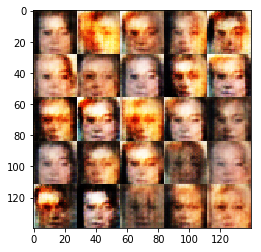

Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 0.6455
Epoch 1/1... Discriminator Loss: 1.4332... Generator Loss: 0.6779
Epoch 1/1... Discriminator Loss: 1.5223... Generator Loss: 0.5976
Epoch 1/1... Discriminator Loss: 1.4579... Generator Loss: 0.7194
Epoch 1/1... Discriminator Loss: 1.4567... Generator Loss: 0.6701
Epoch 1/1... Discriminator Loss: 1.4073... Generator Loss: 0.6188
Epoch 1/1... Discriminator Loss: 1.5052... Generator Loss: 0.6765
Epoch 1/1... Discriminator Loss: 1.4856... Generator Loss: 0.6531
Epoch 1/1... Discriminator Loss: 1.4614... Generator Loss: 0.6968
Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 0.7417


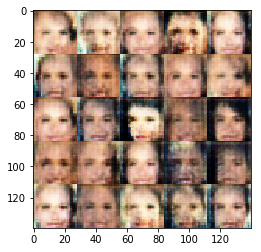

Epoch 1/1... Discriminator Loss: 1.4506... Generator Loss: 0.5941
Epoch 1/1... Discriminator Loss: 1.4466... Generator Loss: 0.6399
Epoch 1/1... Discriminator Loss: 1.4542... Generator Loss: 0.6989
Epoch 1/1... Discriminator Loss: 1.4734... Generator Loss: 0.6416
Epoch 1/1... Discriminator Loss: 1.4300... Generator Loss: 0.7291
Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.6378
Epoch 1/1... Discriminator Loss: 1.4159... Generator Loss: 0.6217
Epoch 1/1... Discriminator Loss: 1.4223... Generator Loss: 0.6647
Epoch 1/1... Discriminator Loss: 1.4473... Generator Loss: 0.6915
Epoch 1/1... Discriminator Loss: 1.4677... Generator Loss: 0.6558


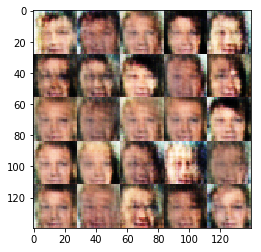

Epoch 1/1... Discriminator Loss: 1.4310... Generator Loss: 0.6555
Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.7090
Epoch 1/1... Discriminator Loss: 1.4665... Generator Loss: 0.6629
Epoch 1/1... Discriminator Loss: 1.4559... Generator Loss: 0.7104
Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.5802
Epoch 1/1... Discriminator Loss: 1.4971... Generator Loss: 0.6583
Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 0.6445
Epoch 1/1... Discriminator Loss: 1.4308... Generator Loss: 0.5557
Epoch 1/1... Discriminator Loss: 1.4779... Generator Loss: 0.7207
Epoch 1/1... Discriminator Loss: 1.4323... Generator Loss: 0.6571


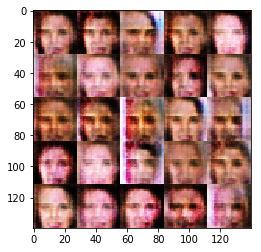

Epoch 1/1... Discriminator Loss: 1.4774... Generator Loss: 0.6640
Epoch 1/1... Discriminator Loss: 1.4644... Generator Loss: 0.6293
Epoch 1/1... Discriminator Loss: 1.4159... Generator Loss: 0.6373
Epoch 1/1... Discriminator Loss: 1.4276... Generator Loss: 0.6925
Epoch 1/1... Discriminator Loss: 1.5194... Generator Loss: 0.6335
Epoch 1/1... Discriminator Loss: 1.4349... Generator Loss: 0.6571
Epoch 1/1... Discriminator Loss: 1.4311... Generator Loss: 0.6645
Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.6799
Epoch 1/1... Discriminator Loss: 1.5071... Generator Loss: 0.7574
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.7184


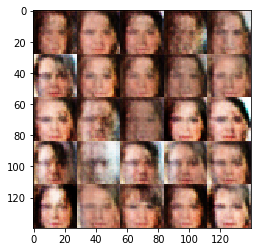

Epoch 1/1... Discriminator Loss: 1.4504... Generator Loss: 0.6780
Epoch 1/1... Discriminator Loss: 1.4058... Generator Loss: 0.6651
Epoch 1/1... Discriminator Loss: 1.4852... Generator Loss: 0.6283
Epoch 1/1... Discriminator Loss: 1.4571... Generator Loss: 0.7287
Epoch 1/1... Discriminator Loss: 1.4785... Generator Loss: 0.5802
Epoch 1/1... Discriminator Loss: 1.4181... Generator Loss: 0.6357
Epoch 1/1... Discriminator Loss: 1.4150... Generator Loss: 0.6115
Epoch 1/1... Discriminator Loss: 1.4419... Generator Loss: 0.5878
Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.6854
Epoch 1/1... Discriminator Loss: 1.5492... Generator Loss: 0.7085


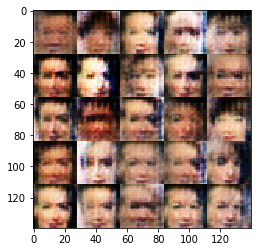

Epoch 1/1... Discriminator Loss: 1.5019... Generator Loss: 0.6472
Epoch 1/1... Discriminator Loss: 1.4006... Generator Loss: 0.6450
Epoch 1/1... Discriminator Loss: 1.4769... Generator Loss: 0.6623
Epoch 1/1... Discriminator Loss: 1.4003... Generator Loss: 0.6679
Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 0.7375
Epoch 1/1... Discriminator Loss: 1.4431... Generator Loss: 0.6173
Epoch 1/1... Discriminator Loss: 1.4216... Generator Loss: 0.6356
Epoch 1/1... Discriminator Loss: 1.5321... Generator Loss: 0.6525
Epoch 1/1... Discriminator Loss: 1.3206... Generator Loss: 0.7169
Epoch 1/1... Discriminator Loss: 1.4272... Generator Loss: 0.6161


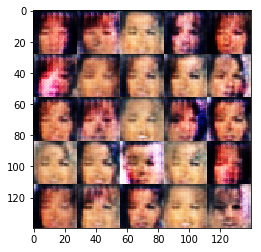

Epoch 1/1... Discriminator Loss: 1.4727... Generator Loss: 0.6580
Epoch 1/1... Discriminator Loss: 1.4333... Generator Loss: 0.6180
Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 0.6552
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6302
Epoch 1/1... Discriminator Loss: 1.4343... Generator Loss: 0.6048
Epoch 1/1... Discriminator Loss: 1.4544... Generator Loss: 0.6125
Epoch 1/1... Discriminator Loss: 1.4426... Generator Loss: 0.7283
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.7083
Epoch 1/1... Discriminator Loss: 1.4908... Generator Loss: 0.6495
Epoch 1/1... Discriminator Loss: 1.3690... Generator Loss: 0.6450


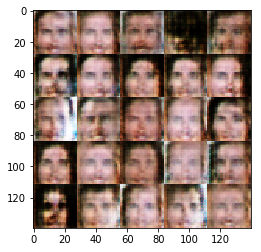

Epoch 1/1... Discriminator Loss: 1.4300... Generator Loss: 0.6312
Epoch 1/1... Discriminator Loss: 1.4501... Generator Loss: 0.5780
Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.6695
Epoch 1/1... Discriminator Loss: 1.4924... Generator Loss: 0.7103
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.6856
Epoch 1/1... Discriminator Loss: 1.4477... Generator Loss: 0.7541
Epoch 1/1... Discriminator Loss: 1.4477... Generator Loss: 0.7248
Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 0.6775
Epoch 1/1... Discriminator Loss: 1.4371... Generator Loss: 0.5922
Epoch 1/1... Discriminator Loss: 1.4540... Generator Loss: 0.6208


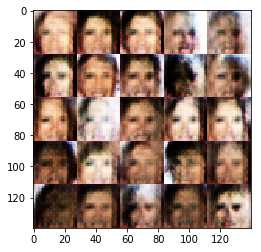

Epoch 1/1... Discriminator Loss: 1.3928... Generator Loss: 0.7347
Epoch 1/1... Discriminator Loss: 1.4512... Generator Loss: 0.6221
Epoch 1/1... Discriminator Loss: 1.3727... Generator Loss: 0.7168
Epoch 1/1... Discriminator Loss: 1.4837... Generator Loss: 0.6661
Epoch 1/1... Discriminator Loss: 1.4246... Generator Loss: 0.6457
Epoch 1/1... Discriminator Loss: 1.4931... Generator Loss: 0.7181
Epoch 1/1... Discriminator Loss: 1.4449... Generator Loss: 0.5505
Epoch 1/1... Discriminator Loss: 1.4293... Generator Loss: 0.5930
Epoch 1/1... Discriminator Loss: 1.4076... Generator Loss: 0.7101
Epoch 1/1... Discriminator Loss: 1.4176... Generator Loss: 0.5745


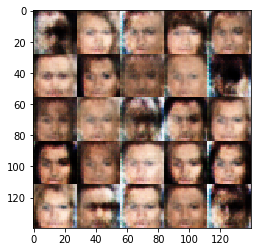

Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.6927
Epoch 1/1... Discriminator Loss: 1.4268... Generator Loss: 0.6015
Epoch 1/1... Discriminator Loss: 1.4233... Generator Loss: 0.6225
Epoch 1/1... Discriminator Loss: 1.4625... Generator Loss: 0.7722
Epoch 1/1... Discriminator Loss: 1.4515... Generator Loss: 0.6295
Epoch 1/1... Discriminator Loss: 1.4459... Generator Loss: 0.6600
Epoch 1/1... Discriminator Loss: 1.5241... Generator Loss: 0.6429
Epoch 1/1... Discriminator Loss: 1.4636... Generator Loss: 0.5986
Epoch 1/1... Discriminator Loss: 1.4162... Generator Loss: 0.6474
Epoch 1/1... Discriminator Loss: 1.4242... Generator Loss: 0.5945


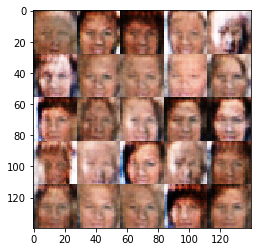

Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.7166
Epoch 1/1... Discriminator Loss: 1.4595... Generator Loss: 0.6342
Epoch 1/1... Discriminator Loss: 1.4352... Generator Loss: 0.6166
Epoch 1/1... Discriminator Loss: 1.4534... Generator Loss: 0.6433
Epoch 1/1... Discriminator Loss: 1.4316... Generator Loss: 0.6594
Epoch 1/1... Discriminator Loss: 1.4073... Generator Loss: 0.6407
Epoch 1/1... Discriminator Loss: 1.4548... Generator Loss: 0.7112
Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 0.6672
Epoch 1/1... Discriminator Loss: 1.4512... Generator Loss: 0.6720
Epoch 1/1... Discriminator Loss: 1.4584... Generator Loss: 0.7094


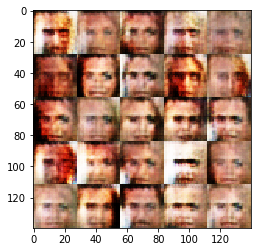

Epoch 1/1... Discriminator Loss: 1.4605... Generator Loss: 0.6240
Epoch 1/1... Discriminator Loss: 1.4300... Generator Loss: 0.6910
Epoch 1/1... Discriminator Loss: 1.4345... Generator Loss: 0.6384
Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.5940
Epoch 1/1... Discriminator Loss: 1.4295... Generator Loss: 0.6573
Epoch 1/1... Discriminator Loss: 1.4336... Generator Loss: 0.6837
Epoch 1/1... Discriminator Loss: 1.4530... Generator Loss: 0.6536
Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 0.6877
Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.6335
Epoch 1/1... Discriminator Loss: 1.4531... Generator Loss: 0.5755


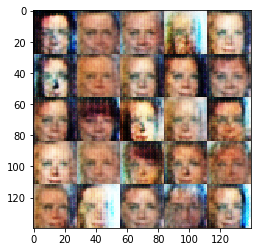

Epoch 1/1... Discriminator Loss: 1.4700... Generator Loss: 0.6305
Epoch 1/1... Discriminator Loss: 1.4240... Generator Loss: 0.7063
Epoch 1/1... Discriminator Loss: 1.4218... Generator Loss: 0.7223
Epoch 1/1... Discriminator Loss: 1.4681... Generator Loss: 0.6355
Epoch 1/1... Discriminator Loss: 1.4698... Generator Loss: 0.5862
Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 0.6511
Epoch 1/1... Discriminator Loss: 1.4374... Generator Loss: 0.6608
Epoch 1/1... Discriminator Loss: 1.4509... Generator Loss: 0.6327
Epoch 1/1... Discriminator Loss: 1.4543... Generator Loss: 0.6735
Epoch 1/1... Discriminator Loss: 1.4372... Generator Loss: 0.6696


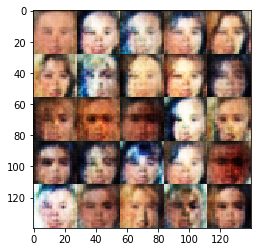

Epoch 1/1... Discriminator Loss: 1.3935... Generator Loss: 0.6915
Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.7473
Epoch 1/1... Discriminator Loss: 1.4277... Generator Loss: 0.6089
Epoch 1/1... Discriminator Loss: 1.4174... Generator Loss: 0.6142
Epoch 1/1... Discriminator Loss: 1.4399... Generator Loss: 0.5956
Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 0.6436
Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 0.6905
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.7372
Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.6288
Epoch 1/1... Discriminator Loss: 1.4310... Generator Loss: 0.6600


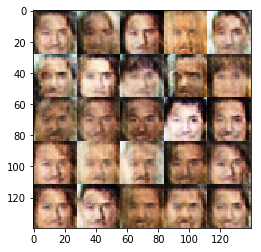

Epoch 1/1... Discriminator Loss: 1.4512... Generator Loss: 0.6170
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.6668
Epoch 1/1... Discriminator Loss: 1.4387... Generator Loss: 0.6795
Epoch 1/1... Discriminator Loss: 1.4270... Generator Loss: 0.6860
Epoch 1/1... Discriminator Loss: 1.4287... Generator Loss: 0.7239
Epoch 1/1... Discriminator Loss: 1.4952... Generator Loss: 0.6243
Epoch 1/1... Discriminator Loss: 1.4941... Generator Loss: 0.7170
Epoch 1/1... Discriminator Loss: 1.4403... Generator Loss: 0.6503
Epoch 1/1... Discriminator Loss: 1.3836... Generator Loss: 0.6735
Epoch 1/1... Discriminator Loss: 1.4439... Generator Loss: 0.6737


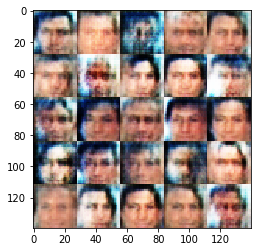

Epoch 1/1... Discriminator Loss: 1.4672... Generator Loss: 0.6406
Epoch 1/1... Discriminator Loss: 1.4457... Generator Loss: 0.6879
Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.5943
Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.6351
Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.6516
Epoch 1/1... Discriminator Loss: 1.4154... Generator Loss: 0.7011
Epoch 1/1... Discriminator Loss: 1.4328... Generator Loss: 0.6439
Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.7096
Epoch 1/1... Discriminator Loss: 1.4160... Generator Loss: 0.7330
Epoch 1/1... Discriminator Loss: 1.4567... Generator Loss: 0.6196


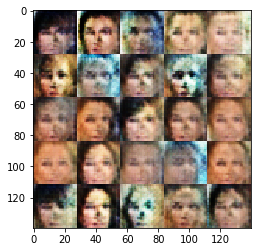

Epoch 1/1... Discriminator Loss: 1.4651... Generator Loss: 0.5816
Epoch 1/1... Discriminator Loss: 1.4061... Generator Loss: 0.6462
Epoch 1/1... Discriminator Loss: 1.4106... Generator Loss: 0.6212
Epoch 1/1... Discriminator Loss: 1.4469... Generator Loss: 0.5578
Epoch 1/1... Discriminator Loss: 1.4194... Generator Loss: 0.6967
Epoch 1/1... Discriminator Loss: 1.4728... Generator Loss: 0.6176
Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.6766
Epoch 1/1... Discriminator Loss: 1.4517... Generator Loss: 0.7285
Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.6618
Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.6249


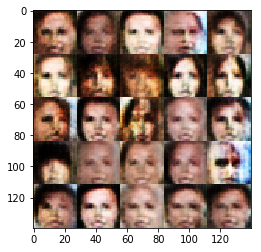

Epoch 1/1... Discriminator Loss: 1.4581... Generator Loss: 0.7117
Epoch 1/1... Discriminator Loss: 1.4264... Generator Loss: 0.6836
Epoch 1/1... Discriminator Loss: 1.4130... Generator Loss: 0.6529
Epoch 1/1... Discriminator Loss: 1.4114... Generator Loss: 0.6668
Epoch 1/1... Discriminator Loss: 1.4080... Generator Loss: 0.6110
Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 0.6429
Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 0.6261
Epoch 1/1... Discriminator Loss: 1.4435... Generator Loss: 0.6684
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.6681
Epoch 1/1... Discriminator Loss: 1.4089... Generator Loss: 0.7016


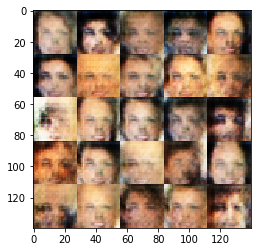

Epoch 1/1... Discriminator Loss: 1.4592... Generator Loss: 0.6687
Epoch 1/1... Discriminator Loss: 1.4131... Generator Loss: 0.6263
Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.6710
Epoch 1/1... Discriminator Loss: 1.4440... Generator Loss: 0.6623
Epoch 1/1... Discriminator Loss: 1.4341... Generator Loss: 0.6053
Epoch 1/1... Discriminator Loss: 1.4329... Generator Loss: 0.7714


IndexError: list index out of range

In [14]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.